In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import community
import warnings
warnings.filterwarnings('ignore')

#plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style="darkgrid") #BBS u mnie poprzednia linia nie działała

## 1. Data Loading
Load cubic spline interpolated price data for all 4 metals (6 series each).

In [ ]:
# Load data files
metals = {
    'Cobalt': pd.read_csv('../../data/ALL_cobalt_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date'),
    'Copper': pd.read_csv('../../data/ALL_copper_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date'),
    'Lithium': pd.read_csv('../../data/ALL_lithium_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date'),
    'Nickel': pd.read_csv('../../data/ALL_nickel_prices_cubic_spline.csv', parse_dates=['Date'], index_col='Date')
}

# Display basic info
for metal, df in metals.items():
    print(f"{metal}: {df.shape[0]} rows, {df.shape[1]} series")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")
    print(f"  Columns: {', '.join(df.columns)}")
    print()

Cobalt: 3876 rows, 6 series
  Date range: 2012-03-02 00:00:00 to 2025-11-18 00:00:00
  Columns: CODALY, COLMEX, COLMEA, COWUXI, COCOMX, COSMMS

Copper: 2342 rows, 6 series
  Date range: 2017-01-01 00:00:00 to 2025-12-31 00:00:00
  Columns: CUDALY, CUCOMX, CULMEX, CUSMMG, CUSHFE, CUETFC

Lithium: 2202 rows, 7 series
  Date range: 2017-05-10 00:00:00 to 2025-12-09 00:00:00
  Columns: LIDALY, LISAME, LICOMX, LILAMC, LIEALC, LIEABG, LILMEX

Nickel: 2857 rows, 6 series
  Date range: 2016-04-04 00:00:00 to 2025-11-18 00:00:00
  Columns: NIDALY, NILMEX, NIETFN, NISHFE, NIWUXI, NIINDA



## 2. Compute Returns

Calculate regular returns (percent change) for all price series.

In [19]:
# Convert prices to returns for all metals
metals_returns = {}

for metal, df in metals.items():
    # Calculate returns: (price_t - price_t-1) / price_t-1
    returns = df.pct_change()
    metals_returns[metal] = returns
    
    print(f"{metal} returns:")
    print(f"  Shape: {returns.shape}")
    print(f"  Mean return range: {returns.mean().min():.6f} to {returns.mean().max():.6f}")
    print(f"  Std dev range: {returns.std().min():.4f} to {returns.std().max():.4f}")
    print()

# Update the metals dictionary to use returns
metals = metals_returns

Cobalt returns:
  Shape: (3876, 6)
  Mean return range: -0.000573 to 0.001289
  Std dev range: 0.0105 to 0.0186

Copper returns:
  Shape: (2342, 6)
  Mean return range: 0.000274 to 0.001018
  Std dev range: 0.0087 to 0.0221

Lithium returns:
  Shape: (2202, 7)
  Mean return range: -0.001831 to 0.000737
  Std dev range: 0.0062 to 0.0652

Nickel returns:
  Shape: (2857, 6)
  Mean return range: -0.000330 to 0.000424
  Std dev range: 0.0155 to 0.0222



## 3. Common Timeframe Identification

Find the overlapping period where all 24 series have valid data.

In [20]:
# Combine all dataframes
all_series = pd.concat(list(metals.values()), axis=1)

# Create mapping of series to metal
series_to_metal = {}
for metal, df in metals.items():
    for col in df.columns:
        series_to_metal[col] = metal

# Exclude LISAME series
lisame_cols = [col for col in all_series.columns if 'LISAME' in col]
if lisame_cols:
    print(f"Excluding LISAME series: {lisame_cols}")
    all_series = all_series.drop(columns=lisame_cols)

print(f"\nCombined dataset: {all_series.shape}")
print(f"Date range before alignment: {all_series.index.min()} to {all_series.index.max()}")
print(f"\nMissing values per series:")
print(all_series.isnull().sum())

Excluding LISAME series: ['LISAME']

Combined dataset: (3946, 24)
Date range before alignment: 2012-03-02 00:00:00 to 2025-12-31 00:00:00

Missing values per series:
CODALY    1292
COLMEX      71
COLMEA    1293
COWUXI    1293
COCOMX    2415
COSMMS    3199
CUDALY    1606
CUCOMX    1606
CULMEX    1606
CUSMMG    1605
CUSHFE    1606
CUETFC    3472
LIDALY    1745
LICOMX    2740
LILAMC    3373
LIEALC    3264
LIEABG    3243
LILMEX    2795
NIDALY    1280
NILMEX    1090
NIETFN    3163
NISHFE    1281
NIWUXI    1281
NIINDA    1280
dtype: int64


In [21]:
# Find common timeframe with complete data
# Strategy: Find the period where all 24 series have non-null values

# Count non-null values per date across all series
complete_dates = all_series.notna().all(axis=1)
complete_data = all_series[complete_dates]

if len(complete_data) == 0:
    # Fallback: use the intersection of date ranges with most data
    print("\nNo dates with all 24 series complete. Finding best overlap...")
    
    # For each series, find first and last valid dates
    series_ranges = {}
    for col in all_series.columns:
        valid_data = all_series[col].dropna()
        if len(valid_data) > 0:
            series_ranges[col] = (valid_data.index.min(), valid_data.index.max())
    
    # Find the common period (latest start, earliest end)
    common_start = max(start for start, end in series_ranges.values())
    common_end = min(end for start, end in series_ranges.values())
    
    print(f"\nCommon period: {common_start} to {common_end}")
    
    # Extract this period
    aligned_data = all_series.loc[common_start:common_end].copy()
    
    # Check coverage
    coverage = aligned_data.notna().sum() / len(aligned_data) * 100
    print(f"\nData coverage in common period:")
    print(coverage.sort_values(ascending=False))
    
    # Use only series with >90% coverage
    good_series = coverage[coverage > 90].index.tolist()
    if len(good_series) < 24:
        print(f"\nUsing {len(good_series)} series with >90% coverage")
        aligned_data = aligned_data[good_series]
    
    # Forward fill small gaps (max 5 days)
    aligned_data = aligned_data.fillna(method='ffill', limit=5)
    
    # Drop any remaining rows with NaN
    aligned_data = aligned_data.dropna()
else:
    common_start = complete_data.index.min()
    common_end = complete_data.index.max()
    aligned_data = complete_data

# Exclude weekend days (Saturday=5, Sunday=6)
weekdays_only = aligned_data.index.dayofweek < 5
aligned_data = aligned_data[weekdays_only]

print(f"\n✓ Final aligned dataset (weekdays only):")
print(f"  Period: {aligned_data.index.min()} to {aligned_data.index.max()}")
print(f"  Duration: {(aligned_data.index.max() - aligned_data.index.min()).days} days")
print(f"  Observations: {len(aligned_data)} (weekdays only)")
print(f"  Series: {len(aligned_data.columns)}")


✓ Final aligned dataset (weekdays only):
  Period: 2024-03-07 00:00:00 to 2025-11-18 00:00:00
  Duration: 621 days
  Observations: 443 (weekdays only)
  Series: 24


## 4. Correlation Analysis

Compute pairwise correlations across all aligned return series.

In [22]:
# Compute correlation matrix
corr_matrix = aligned_data.corr(method='kendall')

print(f"Correlation matrix: {corr_matrix.shape}")
print(f"\nCorrelation statistics:")
print(f"  Mean: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean():.3f}")
print(f"  Median: {np.median(corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]):.3f}")
print(f"  Min: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].min():.3f}")
print(f"  Max: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max():.3f}")

Correlation matrix: (24, 24)

Correlation statistics:
  Mean: 0.080
  Median: 0.044
  Min: -0.135
  Max: 0.789


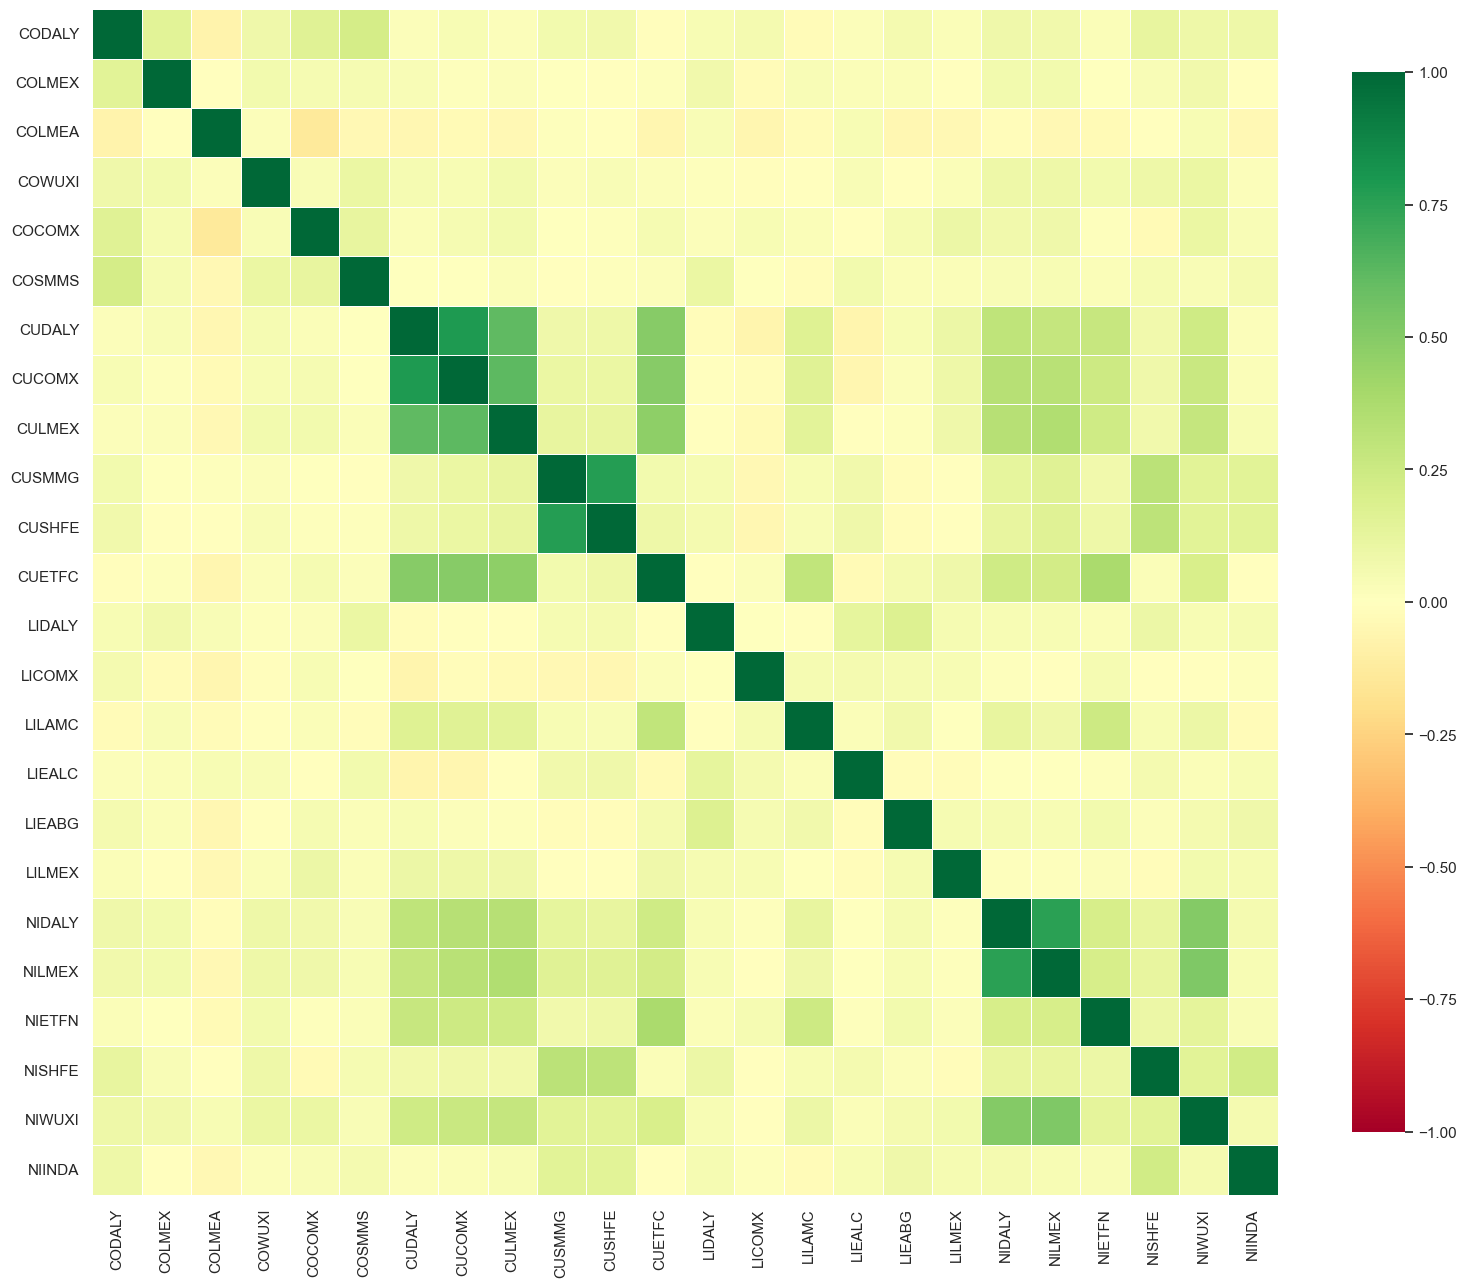

In [23]:
# Visualize full correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('barb_experiments/plots_moving_cor/Kend_cor_mat', dpi=300, bbox_inches='tight')


In [24]:

plt.show()

## 5. Network Visualization

Create a correlation network graph to reveal relationships between metals and series.

**Design choices:**
- **Nodes**: Each return series
- **Node colors**: Color-coded by metal (Cobalt=blue, Copper=orange, Lithium=green, Nickel=purple)
- **Edges**: Shown only for correlations > 0.3 to reduce clutter
- **Edge thickness**: Proportional to correlation strength
- **Layout**: Force-directed layout with community detection to reveal clustering patterns

In [25]:
# Create network graph
G = nx.Graph()

# Add nodes with metadata
#metal_colors = {
    #'Cobalt': '#3498db',   # Blue
    #'Copper': '#e67e22',   # Orange
    #'Lithium': '#27ae60',  # Green
    #'Nickel': '#9b59b6'    # Purple
#}
metal_colors = {
    'Cobalt': '#3498db',   # Vivid Blue (nawiązuje do barwnika kobaltowego)
    'Copper': '#e67e22',   # Carrot Orange (idealny dla miedzi)
    'Lithium': '#95a5a6',  # Concrete Gray (lit jako metal jest srebrzysto-szary)
    'Nickel': '#2ecc71'    # Emerald Green (roztwory soli niklu są jaskrawozielone)
}

node_colors = []
node_labels = {}

for col in aligned_data.columns:
    # Determine metal from mapping (since columns don't have metal prefix)
    metal = series_to_metal[col]
    G.add_node(col, metal=metal)
    node_colors.append(metal_colors[metal])
    node_labels[col] = col

# Add edges for significant correlations (threshold: 0.3)
correlation_threshold = 0
edge_weights = []

for i, col1 in enumerate(aligned_data.columns):
    for col2 in aligned_data.columns[i+1:]:
        corr = corr_matrix.loc[col1, col2]
        if abs(corr) > correlation_threshold:
            G.add_edge(col1, col2, weight=abs(corr))
            edge_weights.append(abs(corr))

print(f"Network statistics:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()} (correlations > {correlation_threshold})")
print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

Network statistics:
  Nodes: 24
  Edges: 276 (correlations > 0)
  Average degree: 23.00


In [26]:
# Detect communities using Louvain method
communities = community.greedy_modularity_communities(G, weight='weight')

print(f"\nCommunity detection:")
print(f"  Number of communities: {len(communities)}")
for i, comm in enumerate(communities):
    metals_in_comm = {}
    for node in comm:
        metal = series_to_metal[node]
        metals_in_comm[metal] = metals_in_comm.get(metal, 0) + 1
    print(f"  Community {i+1}: {len(comm)} nodes - {dict(metals_in_comm)}")


Community detection:
  Number of communities: 3
  Community 1: 11 nodes - {'Lithium': 5, 'Cobalt': 6}
  Community 2: 9 nodes - {'Lithium': 1, 'Copper': 4, 'Nickel': 4}
  Community 3: 4 nodes - {'Nickel': 2, 'Copper': 2}


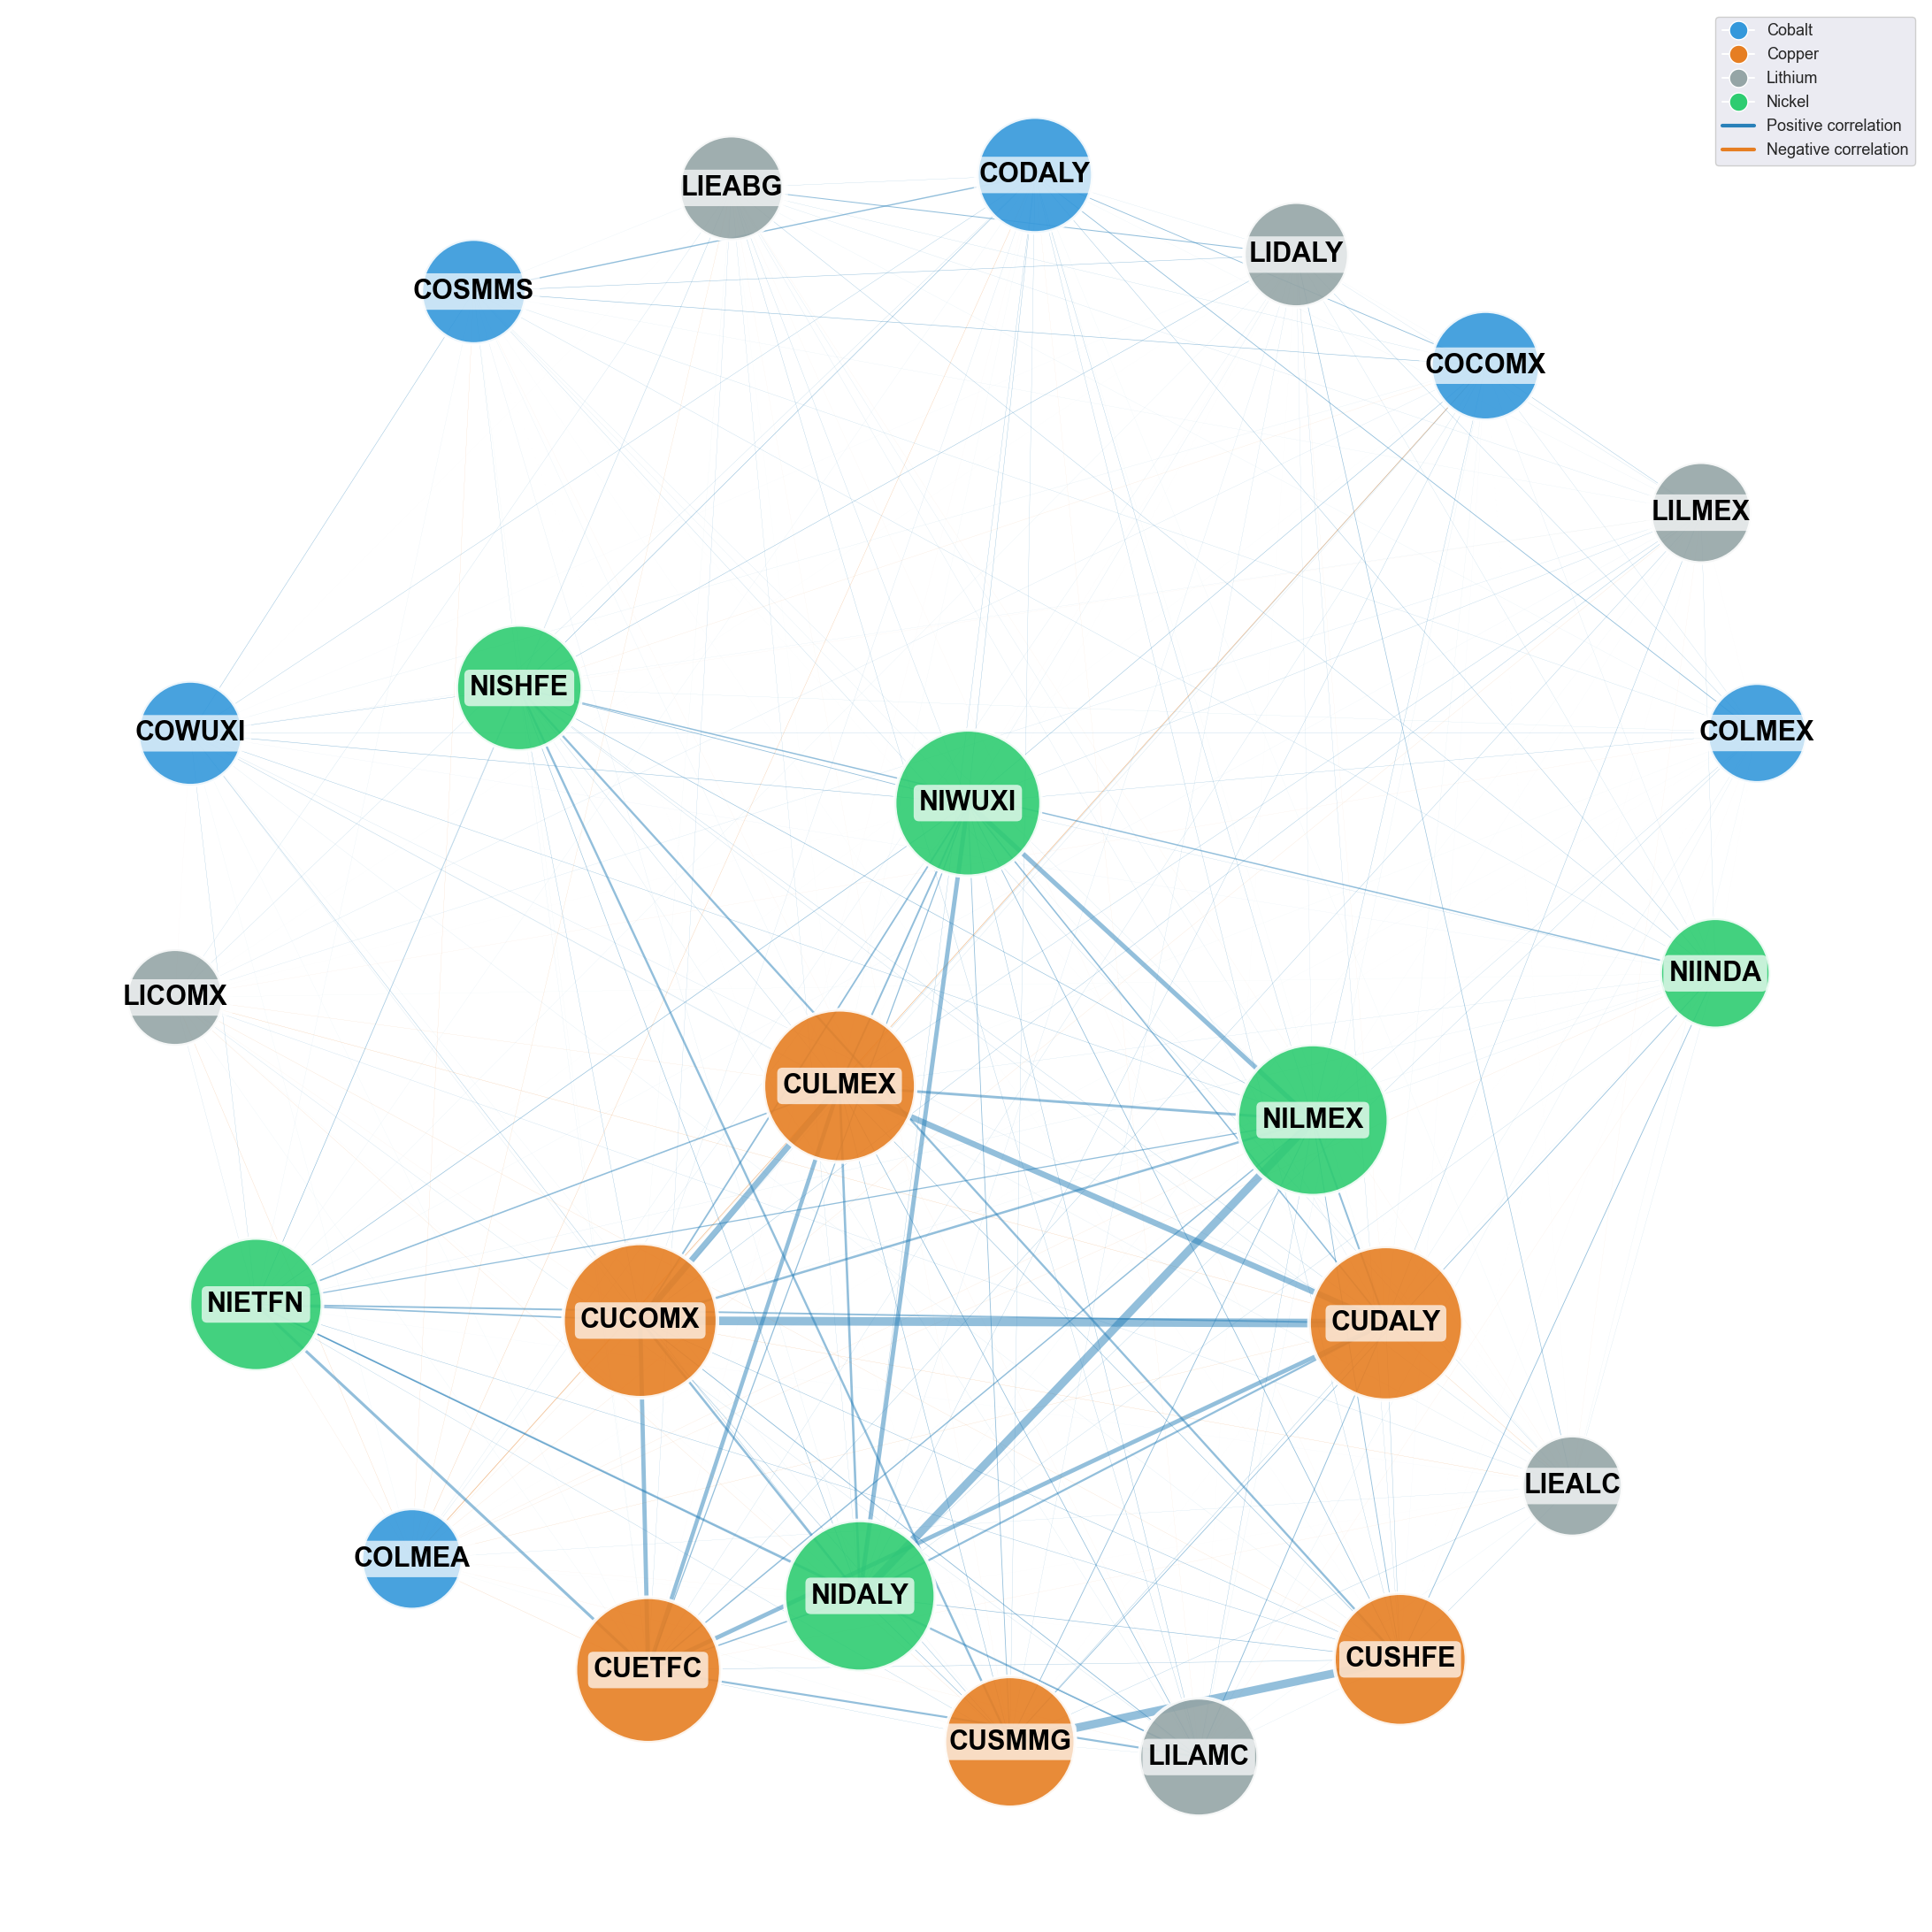

In [27]:
# Obliczamy sumę wartości bezwzględnych korelacji dla każdego metalu
node_strengths = {
    node: sum(abs(corr_matrix.loc[node, neighbor]) for neighbor in G.neighbors(node))
    for node in G.nodes()
}

# Skalujemy siłę do rozmiarów widocznych na wykresie (np. od 5000 do 15000)
# Wzór: (siła * mnożnik) + baza
node_sizes = [node_strengths[node] * 3000 + 4000 for node in G.nodes()]

# Create network visualization
fig, ax = plt.subplots(figsize=(22, 22))

# Use spring layout where distance is inversely proportional to correlation
# Higher weight = stronger attraction = closer nodes
pos = nx.spring_layout(G, k=3, iterations=100, seed=42, weight='weight')

# Prepare edge colors and widths based on correlation sign and strength
edge_colors = []
edge_widths = []

for u, v in G.edges():
    # Get original signed correlation
    corr = corr_matrix.loc[u, v]
    
    # Color: green for positive, red for negative
    if corr > 0:
        #edge_colors.append('#27ae60')  # Green
        edge_color = '#2980b9'  # Nice Blue (dodatnia)
    else:
        #edge_colors.append('#e74c3c')  # Red
        edge_color = '#e67e22'  # Soft Orange (ujemna)
    edge_colors.append(edge_color)

    # Width: emphasize stronger correlations (multiply by 8 instead of 3)
    edge_widths.append(abs(corr) ** 1.5 * 10)  # Power makes differences more pronounced

# Draw edges with colors and varying thickness
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=edge_colors)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                       node_size=node_sizes, alpha=0.9, 
                       linewidths=3, edgecolors='white')

# Draw nodes colored by metal
# nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
#                        node_size=8000, alpha=0.9, linewidths=2.5, edgecolors='white')

# Add labels (small size to avoid clutter)
nx.draw_networkx_labels(G, pos, font_size=22, font_weight='bold', 
                        font_color='black', bbox=dict(boxstyle='round,pad=0.2', 
                        facecolor='white', edgecolor='none', alpha=0.7))

# Add legend for metals
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=color, markersize=15, label=metal)
    for metal, color in metal_colors.items()
]
# Add edge color legend
legend_elements.extend([
    plt.Line2D([0], [0], color='#2980b9', linewidth=3, label='Positive correlation'),
    plt.Line2D([0], [0], color='#e67e22', linewidth=3, label='Negative correlation')
])

ax.legend(handles=legend_elements, loc='upper right', fontsize=13, framealpha=0.95)

# plt.title('Cross-Metal Correlation Network\n(Nodes closer = stronger correlation; Edge thickness ∝ correlation strength)',
#           fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('barb_experiments/plots_moving_cor/Correlation_Network', dpi=300, bbox_inches='tight')
plt.show()

## 6. Within-Metal vs Cross-Metal Correlations

Analyze correlation patterns within and between metals (based on returns).

In [28]:
# Separate within-metal and cross-metal correlations
within_metal_corrs = []
cross_metal_corrs = []

for i, col1 in enumerate(aligned_data.columns):
    metal1 = series_to_metal[col1]
    for col2 in aligned_data.columns[i+1:]:
        metal2 = series_to_metal[col2]
        corr = corr_matrix.loc[col1, col2]
        
        if metal1 == metal2:
            within_metal_corrs.append((metal1, corr))
        else:
            cross_metal_corrs.append((f"{metal1}-{metal2}", corr))

print("Within-metal correlations:")
print(f"  Count: {len(within_metal_corrs)}")
print(f"  Mean: {np.mean([c for _, c in within_metal_corrs]):.3f}")
print(f"  Median: {np.median([c for _, c in within_metal_corrs]):.3f}")

print("\nCross-metal correlations:")
print(f"  Count: {len(cross_metal_corrs)}")
print(f"  Mean: {np.mean([c for _, c in cross_metal_corrs]):.3f}")
print(f"  Median: {np.median([c for _, c in cross_metal_corrs]):.3f}")

Within-metal correlations:
  Count: 60
  Mean: 0.162
  Median: 0.088

Cross-metal correlations:
  Count: 216
  Mean: 0.058
  Median: 0.038


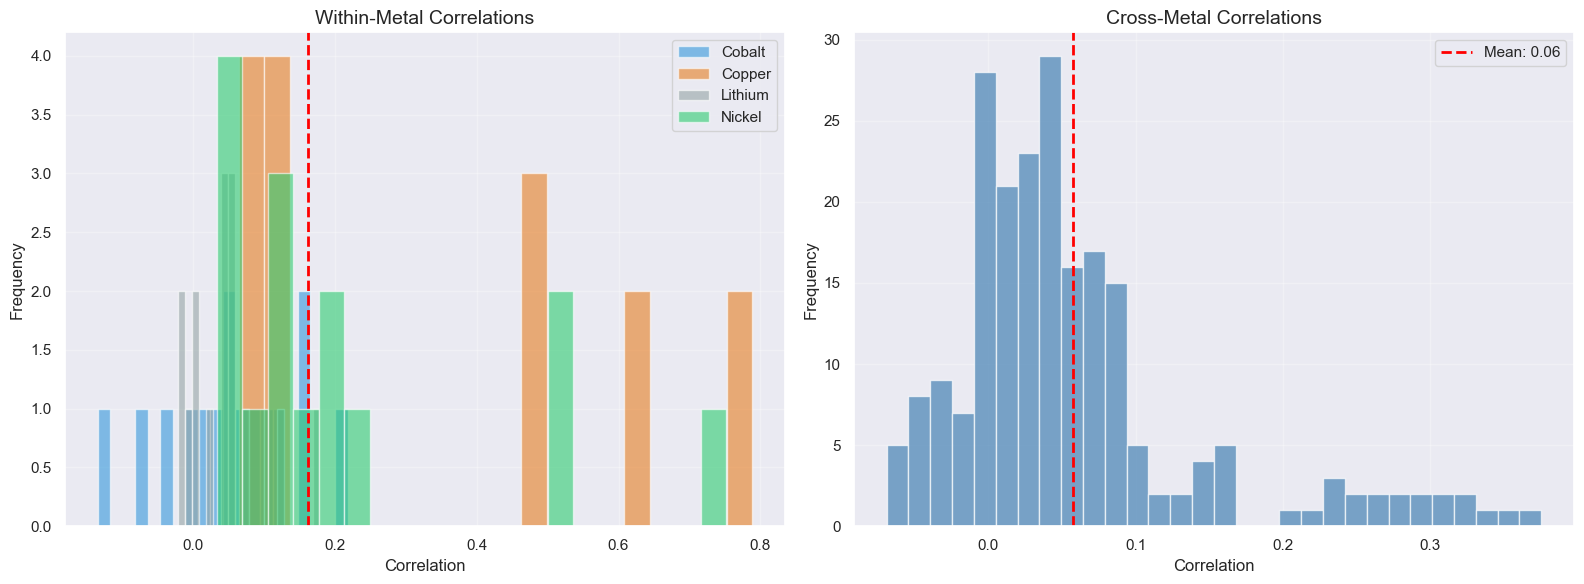

In [ ]:
plt.tight_layout()
plt.savefig('../../barb_experiments/plots_moving_cor/Kend_cor_mat', dpi=300, bbox_inches='tight')
plt.show()

## 6. Key Insights

**Timeframe:** The analysis uses the common period where all series have sufficient data coverage.

**Correlation Patterns:**
- Within-metal correlations tend to be higher (series from the same metal move together)
- Cross-metal correlations reveal economic relationships between different commodity markets
- The network graph reveals natural clustering, with some cross-metal connections indicating shared market drivers

**Network Structure:**
- Node colors clearly distinguish the 4 metals
- Edge thickness shows correlation strength
- Community detection may reveal groups of series that move together regardless of metal type
- Isolated nodes or clusters suggest series with unique price dynamics

## 7. Long-History Series Analysis

Filter series to include only those with at least 3 years of data (≥ 756 trading days) based on their individual history, then analyze their correlation patterns.

In [30]:
# Go back to original returns data and filter series individually
# before creating the aligned dataset

min_observations = 756  # Approximately 3 years of trading days (252 * 3)

print(f"Series filtering criteria: At least {min_observations} observations (~3 years)")
print(f"\nChecking each series individually in original data...\n")

# Reload original returns data (from section 2)
metals_returns_reload = {}
for metal, df in metals.items():
    # metals already contains returns at this point
    metals_returns_reload[metal] = df

# Check each series individually for sufficient history
long_history_series = []
series_info = []

for metal, returns_df in metals_returns_reload.items():
    for col in returns_df.columns:
        # Count non-null values in original data
        valid_count = returns_df[col].notna().sum()
        
        if valid_count >= min_observations:
            long_history_series.append(col)
            series_info.append({
                'Series': col,
                'Metal': metal,
                'Valid_Obs': valid_count
            })
            print(f"✓ {col} ({metal}): {valid_count} observations")
        else:
            print(f"✗ {col} ({metal}): {valid_count} observations (excluded)")

print(f"\n{'='*60}")
print(f"Series with sufficient history: {len(long_history_series)} out of {sum(len(df.columns) for df in metals_returns_reload.values())}")
print(f"{'='*60}\n")

# Create filtered dataset from original returns
# Combine only the long-history series
filtered_series_dict = {}
for metal, returns_df in metals_returns_reload.items():
    metal_long_series = [col for col in returns_df.columns if col in long_history_series]
    if metal_long_series:
        filtered_series_dict[metal] = returns_df[metal_long_series]

# Combine all filtered series
filtered_data = pd.concat(list(filtered_series_dict.values()), axis=1)

# Exclude LISAME if present
if 'LISAME' in filtered_data.columns:
    filtered_data = filtered_data.drop(columns=['LISAME'])
    long_history_series = [s for s in long_history_series if s != 'LISAME']
    print("Excluded LISAME from analysis")

print(f"Combined long-history dataset before alignment:")
print(f"  Date range: {filtered_data.index.min()} to {filtered_data.index.max()}")
print(f"  Total rows: {len(filtered_data)}")
print(f"  Series: {len(filtered_data.columns)}")
print(f"  Missing values per series:")
for col in filtered_data.columns:
    missing = filtered_data[col].isna().sum()
    print(f"    {col}: {missing} missing ({missing/len(filtered_data)*100:.1f}%)")

# Find common timeframe for these series
print(f"\nFinding common timeframe...")

# Get date ranges for each series
series_ranges = {}
for col in filtered_data.columns:
    valid_data = filtered_data[col].dropna()
    if len(valid_data) > 0:
        series_ranges[col] = (valid_data.index.min(), valid_data.index.max())

# Find common period
common_start = max(start for start, end in series_ranges.values())
common_end = min(end for start, end in series_ranges.values())

print(f"Common period: {common_start} to {common_end}")

# Extract common period
filtered_data_aligned = filtered_data.loc[common_start:common_end].copy()

# Exclude weekends
weekdays_only = filtered_data_aligned.index.dayofweek < 5
filtered_data_aligned = filtered_data_aligned[weekdays_only]

# Drop remaining NaN
filtered_data_aligned = filtered_data_aligned.dropna()

print(f"\n✓ Final aligned dataset (long-history series only):")
print(f"  Period: {filtered_data_aligned.index.min()} to {filtered_data_aligned.index.max()}")
print(f"  Duration: {(filtered_data_aligned.index.max() - filtered_data_aligned.index.min()).days} days")
print(f"  Observations: {len(filtered_data_aligned)}")
print(f"  Series: {len(filtered_data_aligned.columns)}")

# Count series by metal
metal_counts = {}
for series in filtered_data_aligned.columns:
    for metal in metals_returns_reload.keys():
        if series in metals_returns_reload[metal].columns:
            metal_counts[metal] = metal_counts.get(metal, 0) + 1
            break

print(f"\nSeries distribution by metal:")
for metal, count in sorted(metal_counts.items()):
    print(f"  {metal}: {count} series")

Series filtering criteria: At least 756 observations (~3 years)

Checking each series individually in original data...

✓ CODALY (Cobalt): 2654 observations
✓ COLMEX (Cobalt): 3875 observations
✓ COLMEA (Cobalt): 2653 observations
✓ COWUXI (Cobalt): 2653 observations
✓ COCOMX (Cobalt): 1531 observations
✗ COSMMS (Cobalt): 747 observations (excluded)
✓ CUDALY (Copper): 2340 observations
✓ CUCOMX (Copper): 2340 observations
✓ CULMEX (Copper): 2340 observations
✓ CUSMMG (Copper): 2341 observations
✓ CUSHFE (Copper): 2340 observations
✗ CUETFC (Copper): 474 observations (excluded)
✓ LIDALY (Lithium): 2201 observations
✓ LISAME (Lithium): 2187 observations
✓ LICOMX (Lithium): 1206 observations
✗ LILAMC (Lithium): 573 observations (excluded)
✗ LIEALC (Lithium): 682 observations (excluded)
✗ LIEABG (Lithium): 703 observations (excluded)
✓ LILMEX (Lithium): 1151 observations
✓ NIDALY (Nickel): 2666 observations
✓ NILMEX (Nickel): 2856 observations
✓ NIETFN (Nickel): 783 observations
✓ NISHFE (

Filtered correlation matrix: (19, 19)

Correlation statistics (long-history series only):
  Mean: 0.085
  Median: 0.048
  Min: -0.127
  Max: 0.779


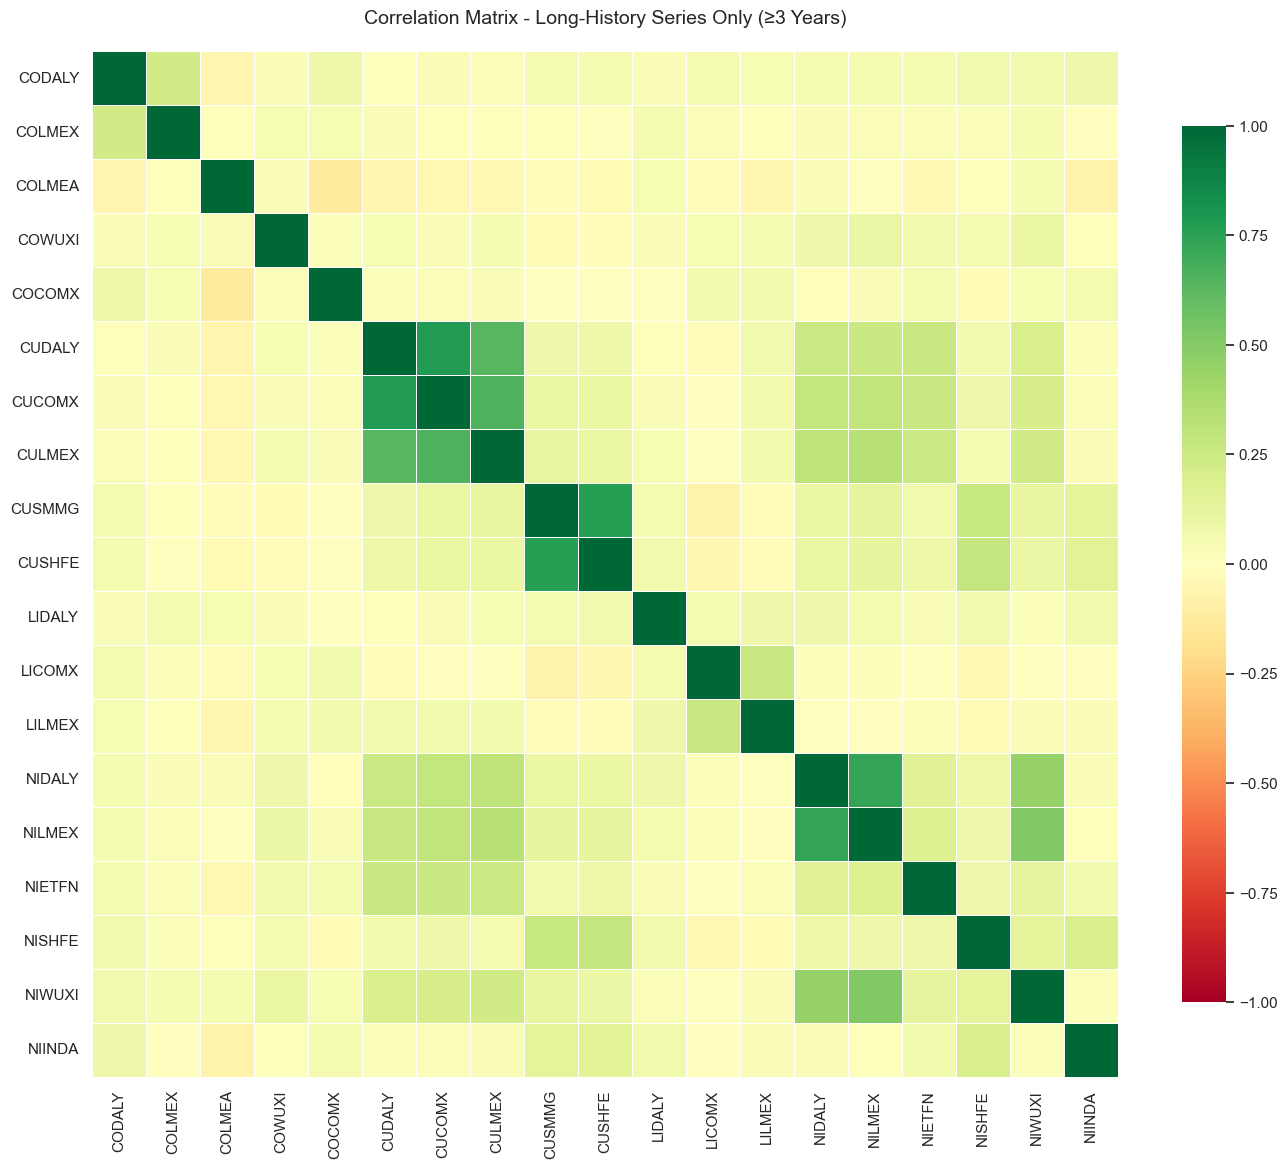

In [31]:
# Compute correlation matrix for long-history series
if filtered_data_aligned.shape[1] == 0:
    print("No series meet the minimum history requirement (≥ 3 years). Skipping correlation and plot.")
    filtered_corr_matrix = pd.DataFrame()
else:
    filtered_corr_matrix = filtered_data_aligned.corr(method='kendall')

    print(f"Filtered correlation matrix: {filtered_corr_matrix.shape}")
    print(f"\nCorrelation statistics (long-history series only):")
    vals = filtered_corr_matrix.values[np.triu_indices_from(filtered_corr_matrix.values, k=1)]
    print(f"  Mean: {vals.mean():.3f}")
    print(f"  Median: {np.median(vals):.3f}")
    print(f"  Min: {vals.min():.3f}")
    print(f"  Max: {vals.max():.3f}")

    # Visualize filtered correlation matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(filtered_corr_matrix, cmap='RdYlGn', center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, annot=False)
    plt.title('Correlation Matrix - Long-History Series Only (≥3 Years)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig('barb_experiments/plots_moving_cor/Kend_cor_mat_long_history', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Visualization: Network diagram of series correlations
import networkx as nx

def plot_correlation_network(corr_matrix, threshold=0.5, layout='spring'):
    """
    Create a network diagram of correlations above a threshold.
    """
    # Create graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(corr_matrix.index)
    
    # Add edges for correlations above threshold
    for i in corr_matrix.index:
        for j in corr_matrix.columns:
            if i < j:  # Avoid duplicate edges
                corr_val = corr_matrix.loc[i, j]
                if abs(corr_val) > threshold:
                    G.add_edge(i, j, weight=abs(corr_val))
    
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G, k=0.5, iterations=50)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G)
    
    # Draw
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Draw edges with varying widths
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=[w * 3 for w in weights], alpha=0.5)
    
    plt.title(f'Correlation Network (threshold={threshold})', fontsize=14)
    plt.axis('off')
    plt.savefig('../../barb_experiments/plots_moving_cor/Correlation_Network', dpi=300, bbox_inches='tight')
    plt.show()
    
    return G

# Plot
G = plot_correlation_network(long_corr_matrix, threshold=0.6, layout='spring')

Filtered network statistics:
  Nodes: 19
  Edges: 171 (correlations > 0)
  Average degree: 18.00

Community detection (long-history series):
  Number of communities: 3
  Community 1: 8 nodes - {'Lithium': 3, 'Cobalt': 5}
  Community 2: 7 nodes - {'Copper': 3, 'Nickel': 4}
  Community 3: 4 nodes - {'Nickel': 2, 'Copper': 2}


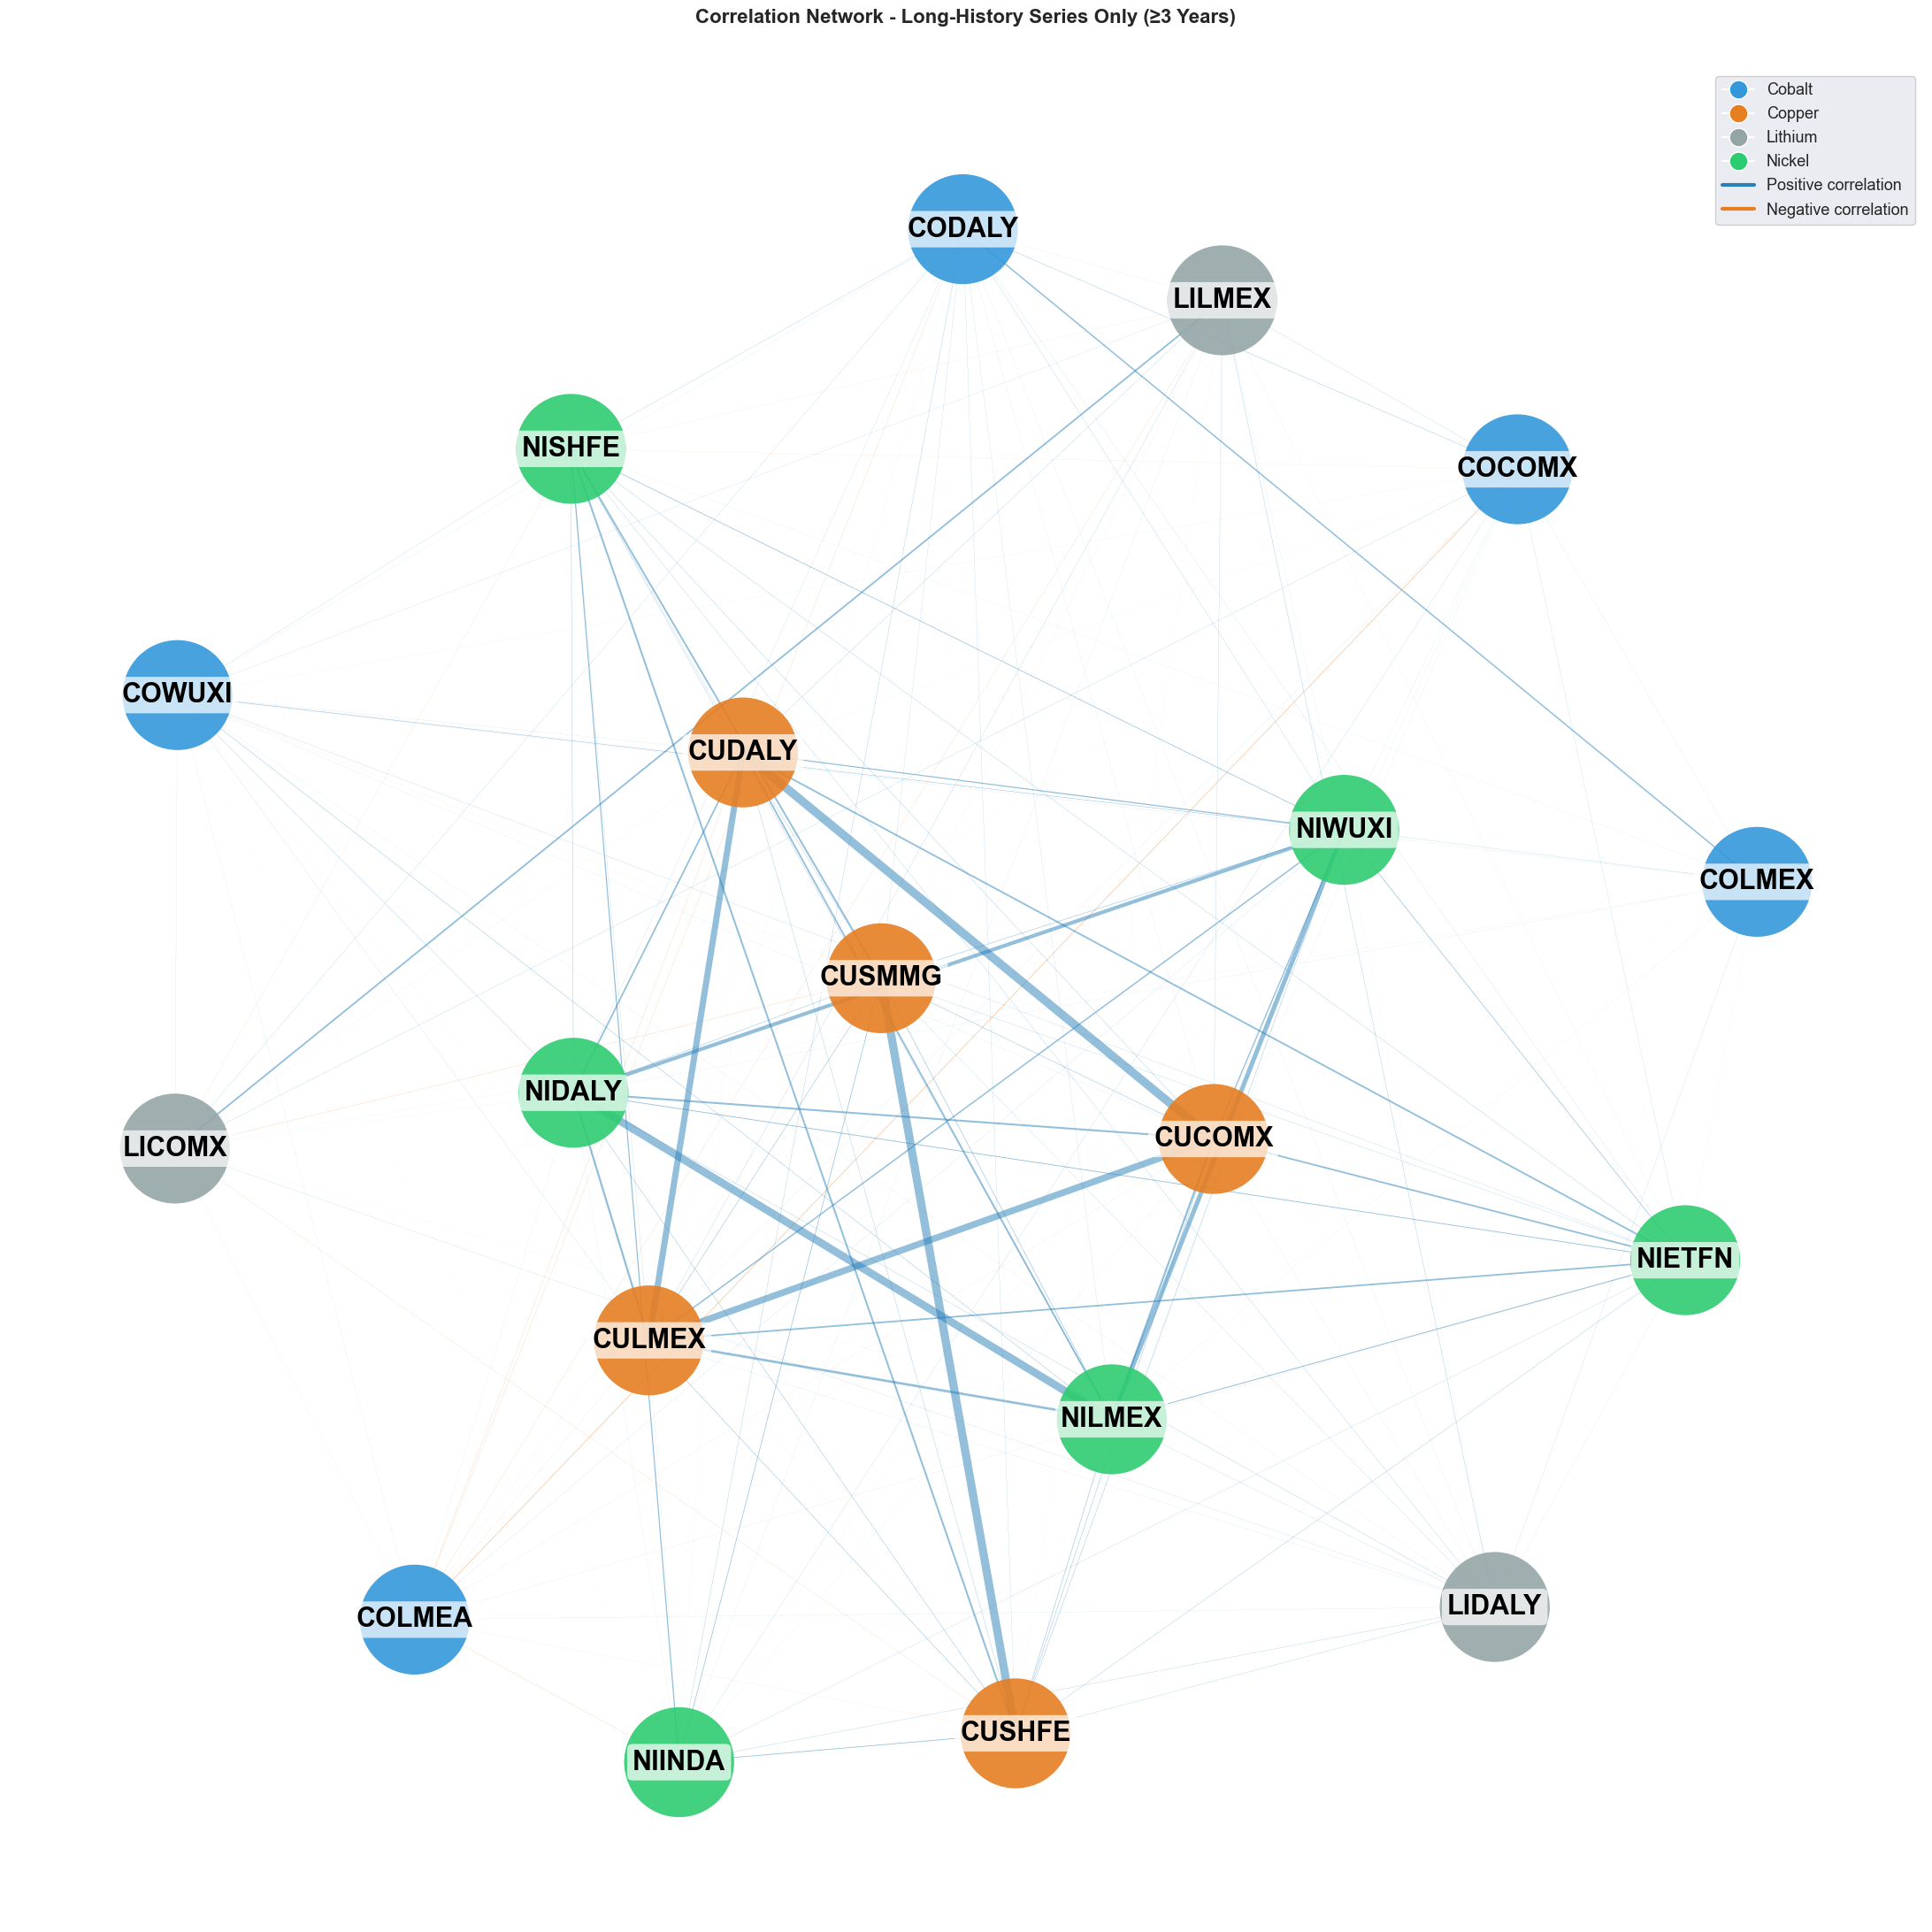

In [38]:
# Visualize filtered network
if G_filtered is not None and G_filtered.number_of_nodes() > 0:
    fig, ax = plt.subplots(figsize=(22, 22))

    # Use spring layout
    pos_filtered = nx.spring_layout(G_filtered, k=3, iterations=100, seed=42, weight='weight')

    # Prepare edge colors and widths
    filtered_edge_colors = []
    filtered_edge_widths = []

    for u, v in G_filtered.edges():
        corr = filtered_corr_matrix.loc[u, v]
        
        if corr > 0:
            edge_color = '#2980b9'  # Blue for positive
        else:
            edge_color = '#e67e22'  # Orange for negative
        filtered_edge_colors.append(edge_color)
        
        filtered_edge_widths.append(abs(corr) ** 1.5 * 10)

    # Draw edges
    nx.draw_networkx_edges(G_filtered, pos_filtered, width=filtered_edge_widths, 
                           alpha=0.5, edge_color=filtered_edge_colors)

    # Draw nodes (uniform size)
    nx.draw_networkx_nodes(G_filtered, pos_filtered, node_color=filtered_node_colors, 
                           node_size=8000, alpha=0.9, linewidths=0, edgecolors='none')

    # Add labels
    nx.draw_networkx_labels(G_filtered, pos_filtered, font_size=22, font_weight='bold', 
                            font_color='black', bbox=dict(boxstyle='round,pad=0.2', 
                            facecolor='white', edgecolor='none', alpha=0.7))

    # Add legend
    ax.legend(handles=legend_elements, loc='upper right', fontsize=13, framealpha=0.95)

    plt.title('Correlation Network - Long-History Series Only (≥3 Years)\n', 
              fontsize=16, pad=20, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('barb_experiments/plots_moving_cor/Correlation_Network_long_history', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping network visualization - no data available.")

In [ ]:
# Compare statistics: All series vs Long-history series
if filtered_data_aligned.shape[1] > 0:
    print("="*60)
    print("COMPARISON: All Series vs Long-History Series")
    print("="*60)

    all_mean = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean()
    filtered_mean = filtered_corr_matrix.values[np.triu_indices_from(filtered_corr_matrix.values, k=1)].mean()

    all_median = np.median(corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)])
    filtered_median = np.median(filtered_corr_matrix.values[np.triu_indices_from(filtered_corr_matrix.values, k=1)])

print(f"\nAll series ({len(aligned_data.columns)} series):")
    print(f"  Observations: {len(aligned_data)}")
    print(f"  Mean correlation: {all_mean:.3f}")
    print(f"  Median correlation: {all_median:.3f}")

    print(f"\nLong-history series ({len(filtered_data_aligned.columns)} series, ≥3 years):")
    print(f"  Observations: {len(filtered_data_aligned)}")
    print(f"  Mean correlation: {filtered_mean:.3f}")
    print(f"  Median correlation: {filtered_median:.3f}")

    print(f"\nDifference:")
    print(f"  Mean correlation: {filtered_mean - all_mean:+.3f}")
    print(f"  Median correlation: {filtered_median - all_median:+.3f}")

    # Visualization of comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Distribution comparison
    all_corrs = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
    filtered_corrs = filtered_corr_matrix.values[np.triu_indices_from(filtered_corr_matrix.values, k=1)]

    axes[0].hist(all_corrs, bins=30, alpha=0.6, label=f'All series (n={len(aligned_data.columns)})', 
                 color='steelblue')
    axes[0].hist(filtered_corrs, bins=30, alpha=0.6, label=f'Long-history (n={len(filtered_data_aligned.columns)})', 
                 color='coral')
    axes[0].axvline(all_mean, color='steelblue', linestyle='--', linewidth=2)
    axes[0].axvline(filtered_mean, color='coral', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Correlation', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Correlation Distribution Comparison', fontsize=14)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Network metrics comparison
    metrics = ['Series Count', 'Mean Corr', 'Median Corr', 'Network Edges']
    all_values = [len(aligned_data.columns), all_mean, all_median, G.number_of_edges()]
    filtered_values = [len(filtered_data_aligned.columns), filtered_mean, filtered_median, 
                      G_filtered.number_of_edges() if G_filtered is not None else 0]

    x = np.arange(len(metrics))
    width = 0.35

    axes[1].bar(x - width/2, all_values, width, label='All series', color='steelblue', alpha=0.8)
    axes[1].bar(x + width/2, filtered_values, width, label='Long-history', color='coral', alpha=0.8)
    axes[1].set_xlabel('Metrics', fontsize=12)
    axes[1].set_ylabel('Value', fontsize=12)
    axes[1].set_title('Network Metrics Comparison', fontsize=14)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('barb_experiments/plots_moving_cor/comparison_all_vs_long_history', dpi=300, bbox_inches='tight')
    plt.show()

    print("="*60)
else:
    print("\nNo long-history series available for comparison.")
    print("="*60)